## Inference model using these strategies

Each technique adds significant time cost. You may play around which combos give the best balance for your specific domain

#### CRFs and Morphological Operations

Refine boundaries and clean up noises

Use PyDenseCRF, employ dilation and erosion

#### Thresholding

Fine tune uncertain regions around boundaries

Apply threshold on logits after softmax

#### Test-Time Augmentation and Multi-Scale

Improve robustness and accuracy, reduce reliance on specific features

Apply augmentations like flipping, rotation, scaling, etc ... Then aggregate results by max/most/mean/weighted on logits/probs/classes

In [1]:
import sys
from pathlib import Path

import numpy as np
import torch
from PIL.Image import Image
from torch import Tensor
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.v2 import functional as TF
from torchvision.utils import draw_segmentation_masks

sys.path.append(str(Path("..").resolve()))
from src.datasets import resolve_metadata
from src.models import FCN_ResNet34_Weights, fcn_resnet34
from src.pipeline import (
    forward_batch,
    inference_with_augmentations,
    TesttimeAugmentations,
)
from src.pipeline.testtime import (
    blur_output,
    morph_pred,
    refine_prob_by_crf,
    threshold_prob,
)
from src.utils.transform import SegmentationTransform
from src.utils.visual import combine_images, draw_mask_on_image

In [2]:
weights = FCN_ResNet34_Weights.VOC2012
model = fcn_resnet34(weights=weights)
transforms = SegmentationTransform()
augment = weights.value.transforms()
dataset = VOCSegmentation(
    r"..\dataset", image_set="val", transforms=transforms, year="2007"
)
metadata = resolve_metadata("VOC")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data: tuple[Tensor, Tensor] = dataset[1]
image, mask = data
model.eval().to(device)
with torch.no_grad():
    images = image.unsqueeze(0)
    logits, _ = forward_batch(model, images, None, augment, None, device)
logit = logits["out"].squeeze(0)
prob = torch.softmax(logit, 0)
pred = logit.argmax(0)

### Simple prediction

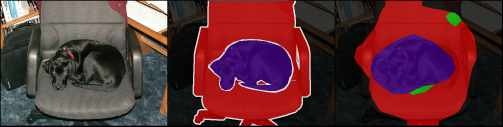

In [4]:
colors = metadata.colors
mask_overlay = draw_mask_on_image(image, mask, colors)
pred_overlay = draw_mask_on_image(image, pred, colors)
snapshot = combine_images([image, mask_overlay, pred_overlay])
snapshot_pil: Image = TF.to_pil_image(snapshot)
display(snapshot_pil.reduce(3))

### CRF

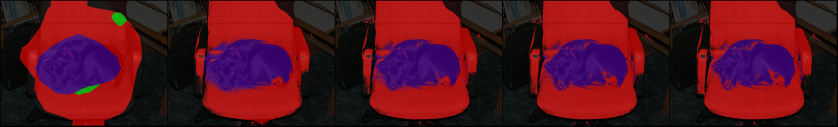

In [5]:
crf_overlays = []
for i in range(0, 10, 2):
    crf_refined = refine_prob_by_crf(prob.numpy(force=True), image, iter=i)
    crf_pred = torch.tensor(crf_refined).argmax(0)
    crf_overlay = draw_mask_on_image(image, crf_pred, colors)
    crf_overlays.append(crf_overlay)

crf_snapshot = combine_images(crf_overlays)
crf_snapshot_pil: Image = TF.to_pil_image(crf_snapshot)
display(crf_snapshot_pil.reduce(3))

### Gaussian blur

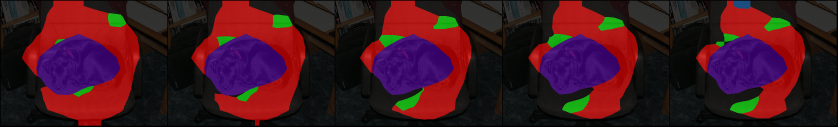

In [6]:
blur_overlays = []
for i in range(5):
    std = i / 10 + 0.5
    blur_logit = blur_output(logit.numpy(force=True), std)
    blur_pred = torch.tensor(blur_logit).argmax(0)
    blur_overlay = draw_mask_on_image(image, blur_pred, colors)
    blur_overlays.append(blur_overlay)

blur_snapshot = combine_images(blur_overlays)
blur_snapshot_pil: Image = TF.to_pil_image(blur_snapshot)
display(blur_snapshot_pil.reduce(3))

### Dilation and erosion

Showing for class 9
Dilation


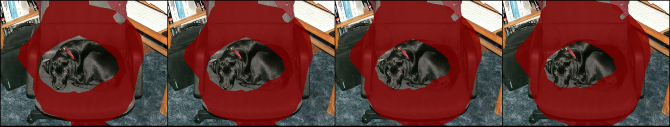

Erosion


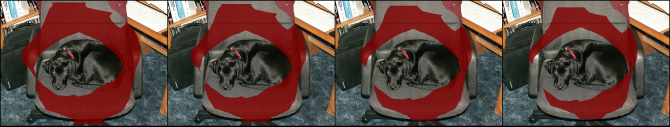

In [7]:
show_class = np.unique(pred)[1]
print("Showing for class", show_class)
for is_dilate in [True, False]:
    morphed_overlays = []
    for iter in range(5, 21, 5):
        morphed_pred = morph_pred(pred.numpy(force=True), is_dilate, iterations=iter)
        morphed_output = torch.tensor(morphed_pred[show_class])
        morphed_overlay = draw_segmentation_masks(
            image, morphed_output, colors=(128, 0, 0)
        )
        morphed_overlays.append(morphed_overlay)

    print("Dilation" if is_dilate else "Erosion")
    morph_snapshot = combine_images(morphed_overlays)
    morph_snapshot_pil: Image = TF.to_pil_image(morph_snapshot)
    display(morph_snapshot_pil.reduce(3))

### Threshold

Showing for class 9


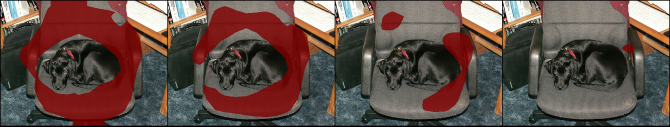

In [8]:
show_class = np.unique(pred)[1]
print("Showing for class", show_class)
threshold_overlays = []
for i in range(1, 5):
    th = i / 5
    threshold_preds = threshold_prob(prob.numpy(force=True), th)
    threshold_output = torch.tensor(threshold_preds[show_class])
    threshold_overlay = draw_segmentation_masks(
        image, threshold_output, colors=(128, 0, 0)
    )
    threshold_overlays.append(threshold_overlay)

threshold_snapshot = combine_images(threshold_overlays)
threshold_snapshot_pil: Image = TF.to_pil_image(threshold_snapshot)
display(threshold_snapshot_pil.reduce(3))

### Augmentation

Augmented results in order [(0.75, False, False, -15), (0.75, False, False, 0), (0.75, False, False, 15), (0.75, True, False, -15), (0.75, True, False, 0), (0.75, True, False, 15), (1, False, False, -15), (1, False, False, 0), (1, False, False, 15), (1, True, False, -15), (1, True, False, 0), (1, True, False, 15), (1.25, False, False, -15), (1.25, False, False, 0), (1.25, False, False, 15), (1.25, True, False, -15), (1.25, True, False, 0), (1.25, True, False, 15)]


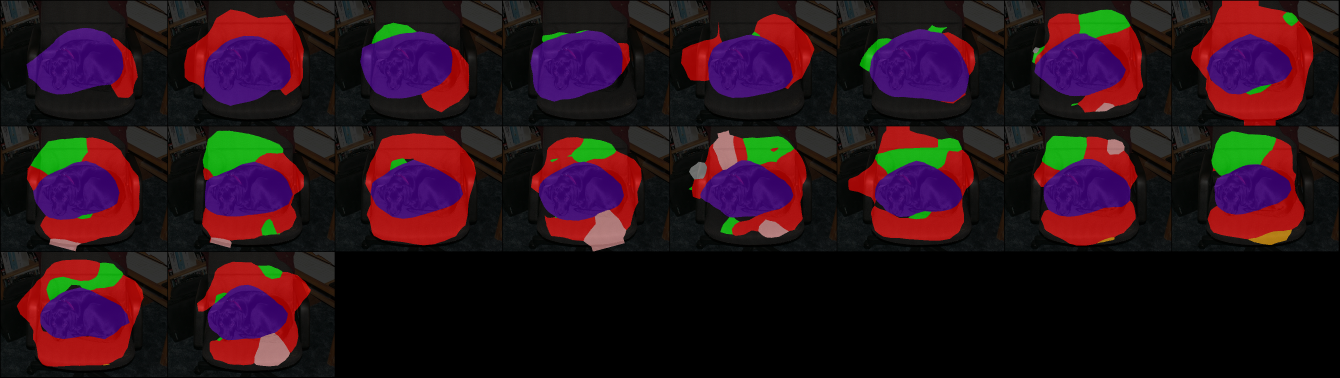

Aggregation by mean of logits VS by max of probs VS by mode of preds


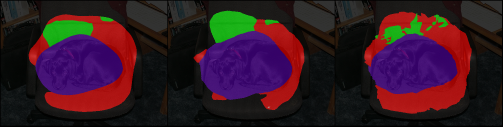

In [9]:
prelim_images, _ = augment(images.to(device), None)
ttas = TesttimeAugmentations(
    (0.75, 1, 1.25), (False, True), (False,), (-15, 0, 15), iter_product=True
)
augmented_logits = inference_with_augmentations(model, prelim_images, ttas)

print("Augmented results in order", ttas.augment_combos)
augmented_overlays = []
for i in range(augmented_logits.size(0)):
    augmented_pred = augmented_logits[i, 0].argmax(0)
    augmented_overlay = draw_mask_on_image(image, augmented_pred, colors)
    augmented_overlays.append(augmented_overlay)
overlays = combine_images(augmented_overlays)
overlays_pil: Image = TF.to_pil_image(overlays)
display(overlays_pil.reduce(3))

# mean of logits
aggregated_logits = torch.mean(augmented_logits, dim=0)
multilogits_preds = aggregated_logits.argmax(1)
multilogits_overlay = draw_mask_on_image(image, multilogits_preds[0], colors)

# max of probs (=== max of logits)
augmented_probs = torch.softmax(augmented_logits, dim=2)
aggregated_probs = torch.max(augmented_probs, dim=0).values
multiprobs_preds = aggregated_probs.argmax(1)
multiprobs_overlay = draw_mask_on_image(image, multiprobs_preds[0], colors)

# mode of preds
augmented_preds = augmented_logits.argmax(dim=2)
aggregated_preds = torch.mode(augmented_preds, dim=0).values
multipreds_overlay = draw_mask_on_image(image, aggregated_preds[0], colors)

print("Aggregation by mean of logits VS by max of probs VS by mode of preds")
multi_snapshot = combine_images(
    [multilogits_overlay, multiprobs_overlay, multipreds_overlay]
)
multi_snapshot_pil: Image = TF.to_pil_image(multi_snapshot)
display(multi_snapshot_pil.reduce(3))